Ce notebook peut être exécuté en ligne avec le binder : 
 [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fds-courses%2Foptimal-filtering-sicom/master?urlpath=lab/tree/notebooks%2F3_Wiener_discret-modeles_AR%2FN5_vocoder_lpc.ipynb)

# Une version (simplifiée) du vocodeur LPC10

0. Chargement et visualisation du signal de parole
1. Encodeur (Analyse) : modèle AR pour un signal de parole. On estime les coefficients et la puissance du bruit (Eq. Yule Walker). 
2. Décodeur (Synthèse) : On génère un signal d'excitation selon le type de son voisé ou non, en entrée du filtre AR (coeff estimé sur un son) afin de synthétise le signal de parole.

Exemple sur un signal de parole mêlant sons voisés ou non

In [1]:
import numpy as np
import pylab
import spectrum
import scipy.signal
from matplotlib import pyplot as plt
from scipy.io import wavfile
from pathlib import Path

# afficher des figures dans le notebook
# utiliser 'widget' au lieu de 'inline' pour un affichage interactif
%matplotlib inline

## Useful function to compute the pitch
def calcul_du_pitch(signal, pitch_min=20, pitch_max=120):
    # pitch_min == 20 is 2.5ms range at fe=8kHz (basic frequency at 400 Hz)
    #  pitch_max == 120 is 15ms (basic frequency at 66 Hz)
    nlags = pitch_max - pitch_min + 1
    autocorr_norm = np.zeros((nlags))
    signal = signal.flatten()

    for k in range(nlags):
        x = signal[: -pitch_min - k]
        xret = signal[pitch_min + k :]
        autocorr_norm[k] = np.sum(x * xret) / np.sqrt(
            np.sum(x ** 2) * np.sum(xret ** 2)
        )

    ipitch = np.argmax(autocorr_norm)
    val = autocorr_norm[ipitch]
    pitch = ipitch + pitch_min

    voise = 1
    if (pitch == pitch_min) or val < 0.8:
        voise = 0
        pitch = pitch_min
    return pitch, voise

## 0. Chargement et visualisation du signal de parole

On charge le signal sonore prononcé par un homme

In [2]:
## Définition des paramètres
N = 240  # 240 échantillons == fenetre de 30ms pour Fe=8kHz
P = 16  # ordre modele AR

## File reading
genre = "homme"
basename = Path("data")  # comptabilité windows/mac/linux
filename = "voix_" + genre + ".wav"
fs, data = wavfile.read(basename / filename)
signal_voice = np.array(data[100:20000], dtype=float)

print("Frequence d'échantillonnage Fe={}Hz".format(fs))

vmax_signal_voice = np.max(np.abs(signal_voice))
signal_voice = signal_voice / vmax_signal_voice  # [-1,1] scaling
nech = len(signal_voice)
nfen = int(np.fix(nech / N))
xtime = np.arange(nech) / fs  # (s)


# zoom intéressants (partie voisée ou non) pour la voix homme
indzoom_nonvois = np.arange(14000, 14500)
indzoom_vois = np.arange(2300, 2800)

Frequence d'échantillonnage Fe=8000Hz


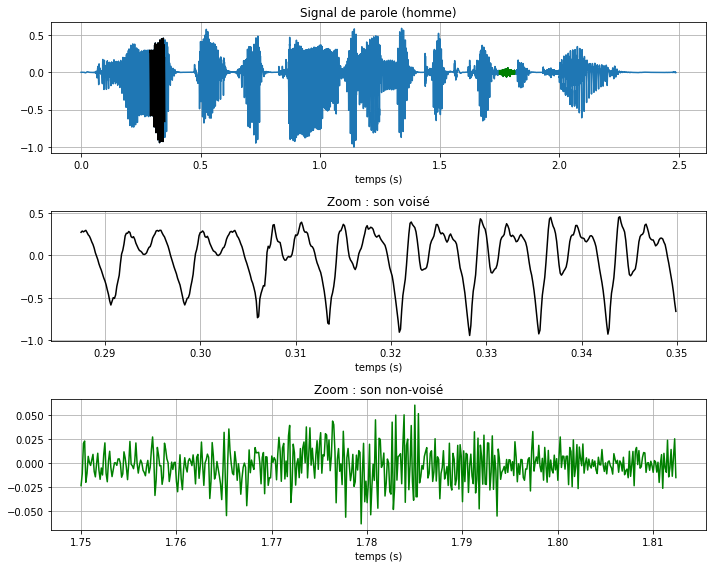

In [3]:
# Visualization
f, axes = plt.subplots(3, 1, figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.grid()
plt.plot(xtime, signal_voice)
plt.plot(xtime[indzoom_vois], signal_voice[indzoom_vois], "k-")
plt.plot(xtime[indzoom_nonvois], signal_voice[indzoom_nonvois], "g-")
plt.title("Signal de parole ({})".format(genre))
plt.xlabel("temps (s)")
plt.subplot(3, 1, 2)
plt.grid()
plt.plot(xtime[indzoom_vois], signal_voice[indzoom_vois], "k-")
plt.title("Zoom : son voisé")
plt.xlabel("temps (s)")
plt.subplot(3, 1, 3)
plt.grid()
plt.plot(xtime[indzoom_nonvois], signal_voice[indzoom_nonvois], "g-")
plt.title("Zoom : son non-voisé")
plt.xlabel("temps (s)")
plt.tight_layout()
plt.show()

Sur les graphes ci dessus, on peut remarquer que pour des sons dits *voisés* (i.e. comme les voyelles), le signal est très *harmonique* ou quasi-périodique

In [5]:
# Play voice signal
from IPython.display import Audio

Audio(signal_voice / np.max(np.abs(signal_voice)), rate=fs)

## 1. **Encodeur**: calcul des coefficients du modèle AR

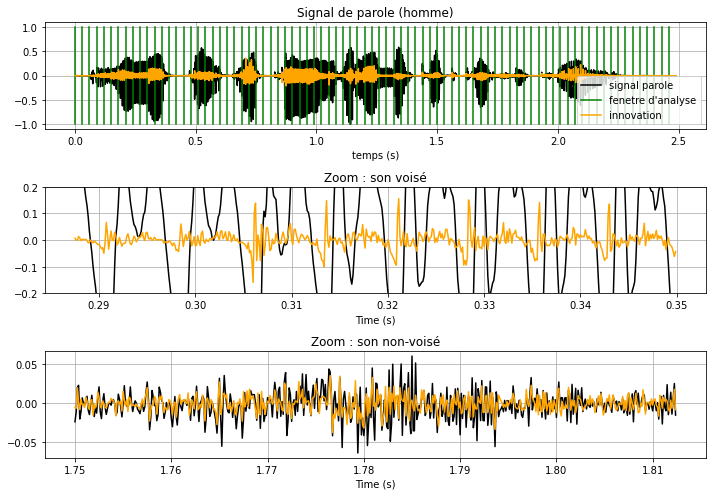

In [6]:
import time

# On stocke dans le fichier les coefficients du vocodage à transmettre
#  dans le canal de communication
fo = open("canal", "wb")

etat_filtre_analyse = np.zeros((P,))
pitch_min = 20
pitch_max = pitch_min + 127
x_fen_precedente = np.zeros((N,))

# Signal résiduel dans le modèle AR (innovation)
e_voice = np.zeros((nech,))
voise = 1

f, ax = plt.subplots(3, 1, figsize=(10, 7))
plt.subplot(3, 1, 1)
plt.grid()
plt.title("Signal de parole ({})".format(genre))
plt.xlabel("temps (s)")
plt.plot(xtime, signal_voice, "k-", label="signal parole")
plt.plot(
    xtime[0] * np.array([1, 1]), 1 * np.array([-1, 1]), "g", label="fenetre d'analyse"
)

#  Le signal est encodé par petites fenetres d'analyse successives afin de
#  vérifier l'hypothèse de stationnarité
for no_fen in range(nfen):

    # Définition de la fenetre d'analyse courante
    n1 = no_fen * N
    n2 = (no_fen + 1) * N
    x = signal_voice[n1:n2]

    # Calcul des coefficients du filtre d'analyse AR (et de synthèse)
    # on utilise ici l'estimateur biaisé de la fonction de corrélation (défaut)
    a, sigma2, _ = spectrum.aryule(x, P, norm="biased")

    # Détermination de la période fondamentale dans le cas voisé
    vecteur = np.concatenate((x_fen_precedente, x))
    pitch, voise = calcul_du_pitch(vecteur, pitch_min, pitch_max)

    # Transfert dans le "canal"
    fo.write(a.astype(np.float16))
    fo.write(np.float16(sigma2))
    fo.write(np.uint8(voise))
    fo.write(np.uint8(pitch))

    #  Calcul et visualisation du signal résiduel sur la fenetre
    signal = np.concatenate((x[::-1], etat_filtre_analyse))
    e_voice_fen = np.zeros((N,))
    coeffs_innov = np.concatenate(([1], a))
    for n in range(N):
        tmp = signal[N - n - 1 : N + P - n]
        e_voice_fen[n] = np.dot(coeffs_innov, tmp)

    e_voice[n1:n2] = e_voice_fen[:]
    etat_filtre_analyse = signal[:P]
    x_fen_precedente = x

    plt.plot(xtime[n2] * np.array([1, 1]), 1 * np.array([-1, 1]), "g")

    # Calcul du périodogramme et du spectre LPC de x(n) et visualisations

fo.close()

plt.plot(xtime, e_voice, color="orange", label="innovation")
plt.legend()
plt.subplot(3, 1, 2)
plt.grid()
plt.plot(xtime[indzoom_vois], signal_voice[indzoom_vois], "k-")
plt.plot(xtime[indzoom_vois], e_voice[indzoom_vois], color="orange")
plt.title("Zoom : son voisé")
plt.xlabel("Time (s)")
plt.ylim((-0.2, 0.2))
plt.subplot(3, 1, 3)
plt.grid()
plt.plot(xtime[indzoom_nonvois], signal_voice[indzoom_nonvois], "k-")
plt.plot(xtime[indzoom_nonvois], e_voice[indzoom_nonvois], color="orange")
plt.title("Zoom : son non-voisé")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

# TODO : montrer les dsp estimées en non-paramétrique et avec le modele AR
# sur quelques fenetres

Sur les graphes ci dessus, que peut-on dire de la forme du signal d'excitation : est-ce un bruit blanc ou plutôt un train d'impulsions périodiques ?

Pour des sons voisés,  on remarque effectivement que pour une modélisation AR le signal d'excitation ressemble à un train d'impulsion périodique. Cela s'explique physiquement par les fermetures/ouvertures périodiques de la glotte lors de la production des sons voisés par l'appareil vocal.

Cete fréquence s'appelle le *pitch*. ou encore la hauteur de la voix parlée. Elle est autour de $100$Hz pour un homme, $200$Hz pour une femme et jusqu'à $400$Hz pour des enfants.

On peut facilement estimer ce pitch, ou son inverse en regardant la valeur du retard obtenu pour le **second** maximum de la fonction d'autocorrélation (*rappel* : la fonction d'autocorrélation d'un signal périodique est une fonction périodique de même période)

## 2. Decodeur :  synthèse du signal selon les coefficients du modèles AR

In [14]:
#  lecture du signal codé et décodage
fo = open("canal", "rb")
# entrée et signal décodé
innov_hat = []
signal_hat = []
etat_filtre_synthese = np.zeros((P,))
# Taille de la fenetre
indice = N - 1

while True:
    # Lecture des infos transmises dans le "canal"
    a = np.array(np.fromfile(fo, np.float16, count=P), dtype="float")

    #  Detecter la fin de fichier (EOF)
    if len(a) == 0:
        break
    # Detecter un problème de format de lecture
    if any(np.isnan(a)):
        print("Warning: canal corrompu")
        break

    sigma2 = float(np.fromfile(fo, np.float16, count=1)[0])
    voise = np.fromfile(fo, np.uint8, count=1)[0]
    pitch = int(np.fromfile(fo, np.uint8, count=1)[0])

    voise = 1

    # Construction de l'entrée du filtre de synthèse
    # sur la fenêtre d'analyse
    e_hat = np.zeros((N,))
    if voise:
        # Train d'impulsions
        indice = indice - N + 1
        if indice < 0:
            indice = -pitch

        amplitude = np.sqrt(pitch * sigma2)

        while (indice + pitch) < N:
            indice = indice + pitch
            e_hat[indice] = amplitude

    else:
        # Bruit blanc
        e_hat = np.sqrt(sigma2) * np.random.randn(N)

    # Calcul du signal synthétique
    x_hat = np.zeros((N,))
    for n in range(N):
        # Equation AR
        x_hat[n] = e_hat[n] - np.dot(a, etat_filtre_synthese)
        #  On décale l'état du filtre (valeurs précédentes) pour
        # inclure la nouvelle valeur décodée
        etat_filtre_synthese[1:P] = etat_filtre_synthese[: P - 1]
        etat_filtre_synthese[0] = x_hat[n]

    # Sauvegarde
    innov_hat += list(e_hat)
    signal_hat += list(x_hat)

fo.close()

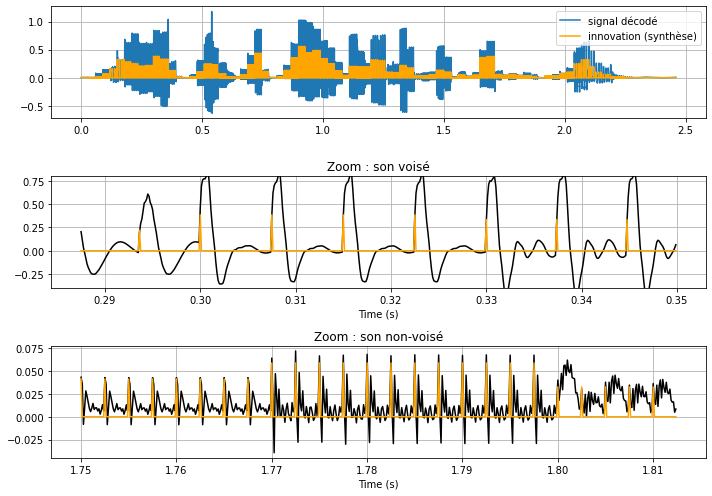

In [15]:
#  Ecriture du fichier wav et affichage du signal de parole décodé
vmax_signal_hat = np.max(np.abs(signal_hat))
signal_hat = np.array(signal_hat)
innov_hat = np.array(innov_hat)
scipy.io.wavfile.write("voix_reconstruite.wav", fs, signal_hat)

xtime_hat = xtime[: nfen * N]

plt.figure(figsize=(10, 7))
plt.subplot(3, 1, 1)
plt.grid()
plt.plot(xtime_hat, signal_hat[: nfen * N], label="signal décodé")
plt.plot(
    xtime_hat, innov_hat[: nfen * N], color="orange", label="innovation (synthèse)"
)
plt.legend()
plt.subplot(3, 1, 2)
plt.grid()
plt.plot(xtime_hat[indzoom_vois], signal_hat[indzoom_vois], "k-")
plt.plot(xtime_hat[indzoom_vois], innov_hat[indzoom_vois], color="orange")
plt.title("Zoom : son voisé")
plt.xlabel("Time (s)")
plt.ylim((-0.4, 0.8))
plt.subplot(3, 1, 3)
plt.grid()
plt.plot(xtime_hat[indzoom_nonvois], signal_hat[indzoom_nonvois], "k-")
plt.plot(xtime_hat[indzoom_nonvois], innov_hat[indzoom_nonvois], color="orange")
plt.title("Zoom : son non-voisé")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

In [16]:
# Play voice signal
from IPython.display import Audio

Audio(signal_hat / np.max(np.abs(signal_hat)), rate=fs)